In [12]:
import tensorflow as tf
import numpy as np
from utils import read_mnist_data, plot_images
from tfops import fc
from time import time
from os.path import exists

In [3]:
data, _ = read_mnist_data()

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Data shapes:
Training - x: (55000, 784), y:(55000, 10)
Test - x: (10000, 784), y:(10000, 10)
Validation - x: (5000, 784), y:(5000, 10)


In [7]:
z_dim = 32

tf.reset_default_graph()

with tf.name_scope('inputs'):
    x = tf.placeholder(tf.float32, (None, 784), 'x')
    epsilon = tf.placeholder(tf.float32, (None, 784), 'epsilon')
    
with tf.name_scope('noiser'):
    x_noisy = x + epsilon
    
with tf.name_scope('denoiser'):
    with tf.name_scope('encoder'):
        z = fc(x_noisy, z_dim, 'None', 'encode')
        
    with tf.name_scope('decoder'):
        x_gen = fc(z, 784, 'sigmoid', 'decode')
        
with tf.name_scope('optimizer'):
    loss = tf.reduce_mean((x - x_gen) ** 2)
    tf.summary.scalar('loss', loss)
    
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)
    
summ = tf.summary.merge_all()

In [28]:
def plot_reconstructions(sess, std=1):
    image_idx = np.random.randint(0, data.validation.num_examples, 11)
    noise = np.random.randn(11, 784) * std

    noisy_img = data.validation.images[image_idx] + noise
    generated_img = sess.run(x_gen, {x_noisy: noisy_img})
    
    plot_images(noisy_img)
    plot_images(generated_img)

In [17]:
batch_size = 256
batches_per_epoch = int(data.train.num_examples / batch_size)

def optimize(epochs=1):
    start_time = time()
    
    writer = tf.summary.FileWriter('output/DenoisingAutoencoder', tf.get_default_graph())
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch in range(epochs):
            for batch in range(batches_per_epoch):
                x_batch, _ = data.train.next_batch(batch_size)
                noise = np.random.randn(batch_size, 784)
                sess.run(optimizer, {x: x_batch, epsilon: noise})
                
                if batch % 1000 == 0:
                    writer.add_summary(sess.run(summ, {x: x_batch, epsilon: noise}), global_step=epoch * batches_per_epoch + batch)
                    
            print("{} / {} ({}%) epochs completed".format(epoch + 1, epochs, np.round((epoch + 1) / epochs * 100), 2))
            plot_reconstructions(sess)
            
        saver.save(sess, 'checkpoints/DenoisingAutoencoder/DenoisingAutoencoder', write_meta_graph=False)
        
    print("Time taken - {}s".format(np.round(time() - start_time, 2)))

INFO:tensorflow:Restoring parameters from checkpoints/DenoisingAutoencoder/DenoisingAutoencoder


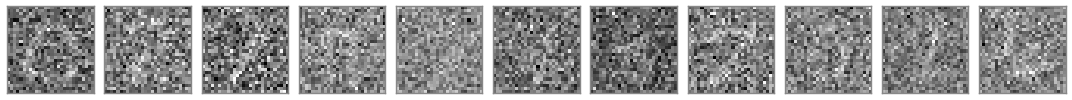

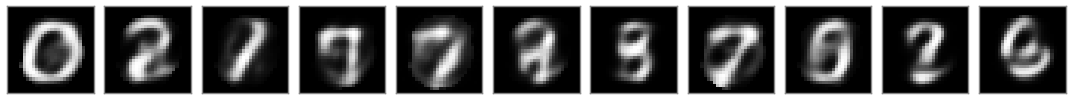

In [29]:
if exists('checkpoints/DenoisingAutoencoder/DenoisingAutoencoder.data-00000-of-00001'):
    with tf.Session() as sess:
        saver = tf.train.Saver()
        saver.restore(sess, 'checkpoints/DenoisingAutoencoder/DenoisingAutoencoder')
        plot_reconstructions(sess, 1)
else:
    optimize(30)